<h1> Training a Transformer model to see.</h1>

Below is a notebook where i attempt to train a ViT (Vision Transformer) to detect the coordinates of mouse cursor from images.

This could be useful for connecting vision to large language models to control computers in a similiar way we do. Taking note of the position of the cursor for example and moving it to interact with a page or application.
<br>
<br>
Its an interesting area of research at the moment using transformers and LLM's to control the keyboard and mouse and navigate around a website.
<br>
I thought this could also be useful to apply to more general applications such as windows apps that are running in closed environments. The typical approach at the moment is to train LLMs to predict the html of a site which therefore makes it easier for a language model to interact with. Of course as humans we do need to interact with the html so i thought i would train a vision model to replicate how we use computers.
<br> 
I have been inspired by the following papers most notably:


*   Pix2ACT - From Pixels to UI Actions -Shaw et al (Google) https://arxiv.org/pdf/2306.00245.pdf
*   Instruction-finetuned foundation models for multimodal web navigation - Furuta, et al - https://huggingface.co/papers/2305.11854
*   Mind2Web - https://arxiv.org/abs/2306.06070

Of course the original vision transformer model itself too.
*   An image is worth 16x6 words (Google) - https://arxiv.org/pdf/2010.11929v2.pdf




**The Dataset**

I have developed a novel way to create synthetic data in this case collating full screen images and overlaying a cursor (whilst taking note of the cursor coordinates) as part of my training data. A future way to improve this would be to collect screenshots from windows applications or general computer screenshots to help the models accuracy and further train a model to click buttons, scroll pages etc.

**Leveraging LLMS to interact with a web browser**

An example graphic from Furutu et al on how they are using LLMs in this case (T5) to interact with a web application. The ViT is the part im exploring in this notebook.

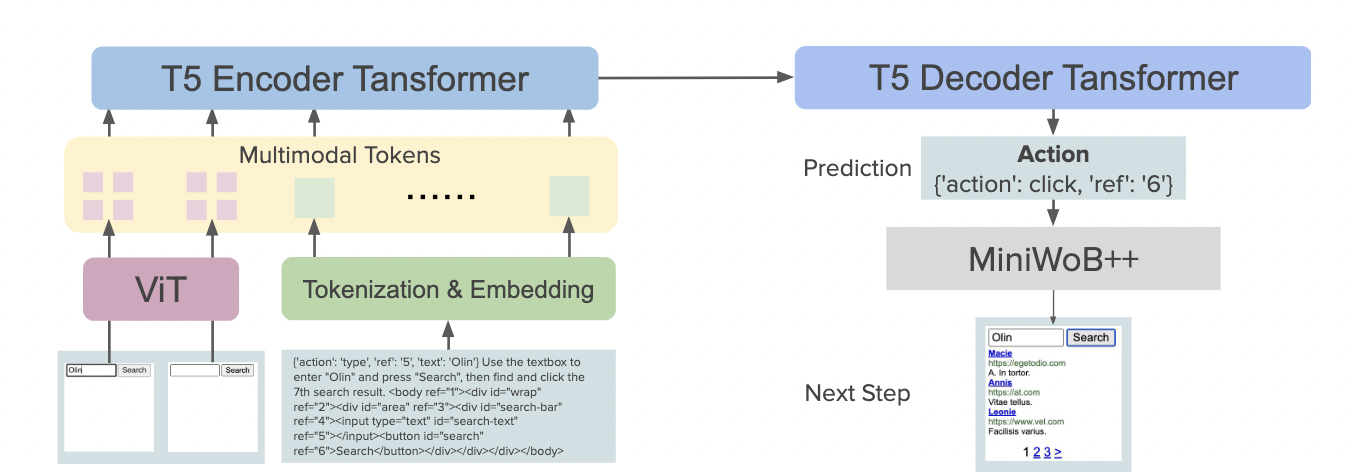

In [ ]:
!pip install transformers datasets accelerate

In [2]:
import os
from PIL import Image
import numpy as np

cursor = Image.open('/content/cursor-small.png')

In [3]:
cursor.show()

In [4]:
cursor.size

(15, 15)

In this example im adding the cursor onto the 'imagenette' dataset this a common datatset used for object detection in computer vision. Im simulating screenshots to try and train a model to find the cursor in the image even with noise in the background.

In [7]:
from datasets import load_dataset

dataset = load_dataset('frgfm/imagenette', 'full_size')

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9469
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3925
    })
})

In [9]:
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import torch

def add_cursor(batch):
    # Initialize the new 'img' and 'cursor_pos' lists
    new_images = []
    cursor_positions = []
    
    # Iterate over each example in the batch
    for i, img in enumerate(batch['image']):
        # Convert the screenshot data to a PIL Image
        screenshot = Image.fromarray(np.uint8(img)).convert('RGB')

        # Resize the cursor
        cursor_resized = cursor.resize((10,10))  # Adjust the size as needed

        # Generate a random position for the cursor
        x = np.random.randint(0, screenshot.width - cursor_resized.width)
        y = np.random.randint(0, screenshot.height - cursor_resized.height)

        # Place the cursor on the screenshot
        screenshot.paste(cursor_resized, (x, y), cursor_resized)

        # Convert the image to a tensor and add it to the example
        transform = Compose([
            Resize((224, 224)),  # Resize to fit ViT input
            ToTensor(),  # Convert to PyTorch tensor
        ])
        transformed_screenshot = transform(screenshot)

        # Add the tensor to the new_images list
        new_images.append(transformed_screenshot)

        # Add the cursor's position to the cursor_positions list
        cursor_positions.append(torch.tensor([x, y], dtype=torch.float))
    
    # Replace the 'img' and 'cursor_pos' fields in the batch with our new data
    batch['image'] = new_images
    batch['label'] = cursor_positions

    return batch


In [11]:
# Shuffle the dataset
shuffled_dataset = dataset['train'].shuffle(seed=42)

# Take 1,000 images for training
train_dataset = shuffled_dataset.select(range(1000))

# Take another 500 images for testing from the remaining data
test_dataset = shuffled_dataset.select(range(1000, 1500))


In [12]:
train_dataset= train_dataset.remove_columns('label')
test_dataset= test_dataset.remove_columns('label')

In [13]:
train_dataset

Dataset({
    features: ['image'],
    num_rows: 1000
})

In [14]:
train_dataset = train_dataset.map(add_cursor, batched=True)
test_dataset = test_dataset.map(add_cursor, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<h3> Example of a cursor that has been overlaid on to an image below. The cursor is randomly put on the screen at certain positions. </h3>

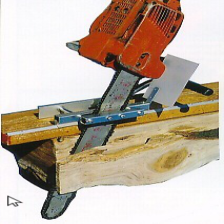

In [15]:
from torchvision.transforms import ToPILImage
import torch

img_data = train_dataset[3]['image']

# Convert the image data to a tensor if it's not already
if not isinstance(img_data, torch.Tensor):
    img_tensor = torch.tensor(img_data)
else:
    img_tensor = img_data

# If your tensor is on GPU, move it to CPU
if img_tensor.is_cuda:
    img_tensor = img_tensor.cpu()

# Convert the tensor back to a PIL Image
img = ToPILImage()(img_tensor)

# Now you can display it
img.show()


In [16]:
img.size

(224, 224)

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9469
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3925
    })
})

In [33]:
# Rename 'img' to 'pixel_values' in both the training and validation datasets
train_dataset = train_dataset.rename_column('image', 'pixel_values')
test_dataset = test_dataset.rename_column('image', 'pixel_values')

The custom ViT model. I have added a final linear layer to output the x and y coordinates. This layer works like a 'hat' where the Vit typically outputs a class it now outputs the coordinates instead.

In [34]:
from transformers import ViTModel

class CustomViTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Assume the base model is a pretrained Vision Transformer
        self.base_model = ViTModel(config)
        self.regressor = nn.Linear(config.hidden_size, 2) # this outputs our x and y coords
        
    def forward(self, pixel_values, labels=None):
        outputs = self.base_model(pixel_values=pixel_values)
        logits = self.regressor(outputs.last_hidden_state[:, 0])

        # Compute the loss if the 'labels' argument is provided
        loss = None
        if labels is not None:
            loss_fn = nn.MSELoss()  # Use mean squared error loss for regression
            loss = loss_fn(logits, labels)

        return {
            'loss': loss,
            'logits': logits,
            'hidden_states': outputs.hidden_states,
            'attentions': outputs.attentions,
        }


In [35]:
from transformers import TrainingArguments, Trainer

# TrainingArguments hold all the hyperparameters for training
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=1e-4,
)

# Initialize the model with the ViT config
config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
model = CustomViTModel(config)

# Trainer wraps up the training job along with model and datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()


Step,Training Loss


Step,Training Loss


TrainOutput(global_step=126, training_loss=75888.81746031746, metrics={'train_runtime': 263.9852, 'train_samples_per_second': 7.576, 'train_steps_per_second': 0.477, 'total_flos': 0.0, 'train_loss': 75888.81746031746, 'epoch': 2.0})